In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import os
from oiffile import imread
from PIL import Image
import random
import skimage
from skimage.transform import resize
import matplotlib
import glob
import torch
import sys
sys.path.insert(0, '..')
import scipy.io as sio
import matplotlib.patches as patches
from skimage.measure import label,regionprops
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.transform import rescale
import dognet
from sklearn.metrics import roc_curve, auc
import os, os.path
%matplotlib inline

In [2]:
from skimage.draw import circle
def make_labels(img,ys,xs,radius=4):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(xv,yv,radius,labels.shape)
        
        labels[rr,cc]=1
    return labels

#Train set
def make_training_set(labels,indexes):
    train_images = []
    train_labels = []
    for i in indexes:
        if len(labels[i])==0:
            d = np.zeros_like(collman[0,0,:,:])
        else:
            d = make_labels(collman[:,0],np.array(labels[i])[:,0],np.array(labels[i])[:,1])
        train_images.append(collman[:,i])
        train_labels.append(d)
    return train_images,train_labels

In [15]:
i = 50

if i<10:
    n = '000%s' % (i)
elif i <100:
    n = '00%s' % (i)
else:
    n = '0%s' % (i)

#fdir = '/Volumes/BACKUP/pcp2cre_syptom_568_mglur1_1to200_647_1to250_vgat_1to200_488_1to250/FV10__20190507_224650_flocculusA/Track%s' % (n)

fdir = '/Users/morganneuwirth/Desktop/flocculusA/Track%s' % (n)

im_name = 'Image%s_01.oib' % (n)
image = imread(os.path.join(fdir,im_name))

3


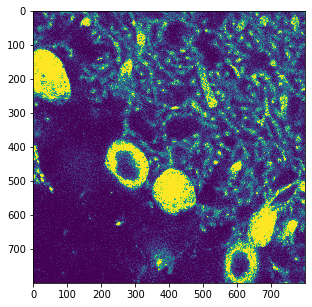

In [17]:
file_name= 'Track%s' % (n)

z_slice=random.randint(0,15)
#z_slice=3
print(z_slice)

if z_slice < 10:
    v1 = str(z_slice)
    v = '0%s' % (v1)
else:
    v = str(z_slice)

# open a txt file for logging annotation
annotation_filename = "%s_%s\n" % (file_name,v)
with open("../datasets/flocculusA/imagesUsed.txt", "a") as fin:
    fin.write(annotation_filename )

# load pre-computed medians of slices
medianTotal= np.double(np.load("../datasets/flocculusA/medianTotal.npy"))

# make two copies of image for the selected slice
image_save = np.double(image[:,z_slice,:,:].transpose(1,2,0))
image_view = np.double(image[:,z_slice,:,:].transpose(1,2,0))
# normalize the image used for view
image_view[:,:,0] = image_view[:,:,0]/medianTotal[0][z_slice]
image_view[:,:,1] = image_view[:,:,1]/medianTotal[1][z_slice]
image_view[:,:,2] = 0
# normalize the iamge used for saving
image_save[:,:,0] = image_save[:,:,0]/medianTotal[0][z_slice]
image_save[:,:,1] = image_save[:,:,1]/medianTotal[1][z_slice]
image_save[:,:,2] = image_save[:,:,2]/medianTotal[2][z_slice]

# manually anotate the selected image
#%matplotlib qt
%matplotlib inline
plt.figure(figsize=(30,30)) ######## CHANGE
plt.imshow(image_view[:,:,1])
plt.show()
pt = np.asarray(plt.ginput(100,timeout = -1)) ######## change number of clicks


pt = []
rawStr="../datasets/flocculusA/rawCoordinates/%s_%s_rawCoords.npy" % (file_name,v)
np.savetxt(rawStr, pt)
    
image_save = resize(image_save,(400,400), order=1, preserve_range=True)

h=400
w=400
tol=30

UL=(image_save[0:int(h/2+tol),0:int(w/2+tol),:])       
UR=(image_save[0:int(h/2+tol),int(w/2-tol):w,:])
LL=(image_save[int(h/2-tol):h,0:int(w/2+tol),:])
LR=(image_save[int(h/2-tol):h,int(w/2-tol):w,:])
    
smallPictures=[UL,UR,LL,LR]
 
b = [[] for i in range(0,4)]

for j in pt:
    if j[0] < 460 and j[1] < 460:
        (b[0]).append(.5*np.array(j))
    elif j[0] > 340 and j[1] < 460:
        j[0]=j[0]-340
        (b[1]).append(.5*np.array(j))
    elif j[0] < 460 and j[1] > 340:
        j[1]=j[1]-340
        (b[2]).append(.5*np.array(j))
    elif j[0] > 340 and j[1] > 340:
        j[0]=j[0]-340
        j[1]=j[1]-340
        (b[3]).append(.5*np.array(j))

collman = np.transpose((np.stack(smallPictures,axis=3)),(2,3,0,1))
train_images,train_labels = make_training_set(b,range(0,4))

smallPicturesNames=['UL','UR','LL','LR']

for j in range(0,4): 
    coordsStr="../datasets/flocculusA/trainingCoordinates/%s_%s_%s_coords" % (file_name,v,smallPicturesNames[j])
    maskStr="../datasets/flocculusA/trainingMasks/%s_%s_%s_mask.npy" % (file_name,v,smallPicturesNames[j])
    imageStr="../datasets/flocculusA/trainingImages/%s_%s_%s_image.npy" % (file_name,v,smallPicturesNames[j])
    
    np.save(maskStr, train_labels[j])
    np.save(imageStr, train_images[j])
    np.savetxt(coordsStr, b[j], delimiter=',')

In [3]:
path1 = glob.glob("../datasets/flocculusA/trainingMasks/*.npy")
trainingMasks=[]
for i in path1:
    im = np.load(i)
    trainingMasks.append(im)
    
path2 = glob.glob("../datasets/flocculusA/trainingImages/*.npy")
trainingImages=[]
stacking_images=[]
for i in path2:
    im = np.load(i)
    image1 = np.copy(im/np.mean(im))
    stacking_images.append(image1)
    trainingImages.append(image1)
new_images = np.stack(trainingImages, axis = 3)
collman = np.transpose(new_images,(0,3,1,2))

In [4]:
len(trainingMasks)

36

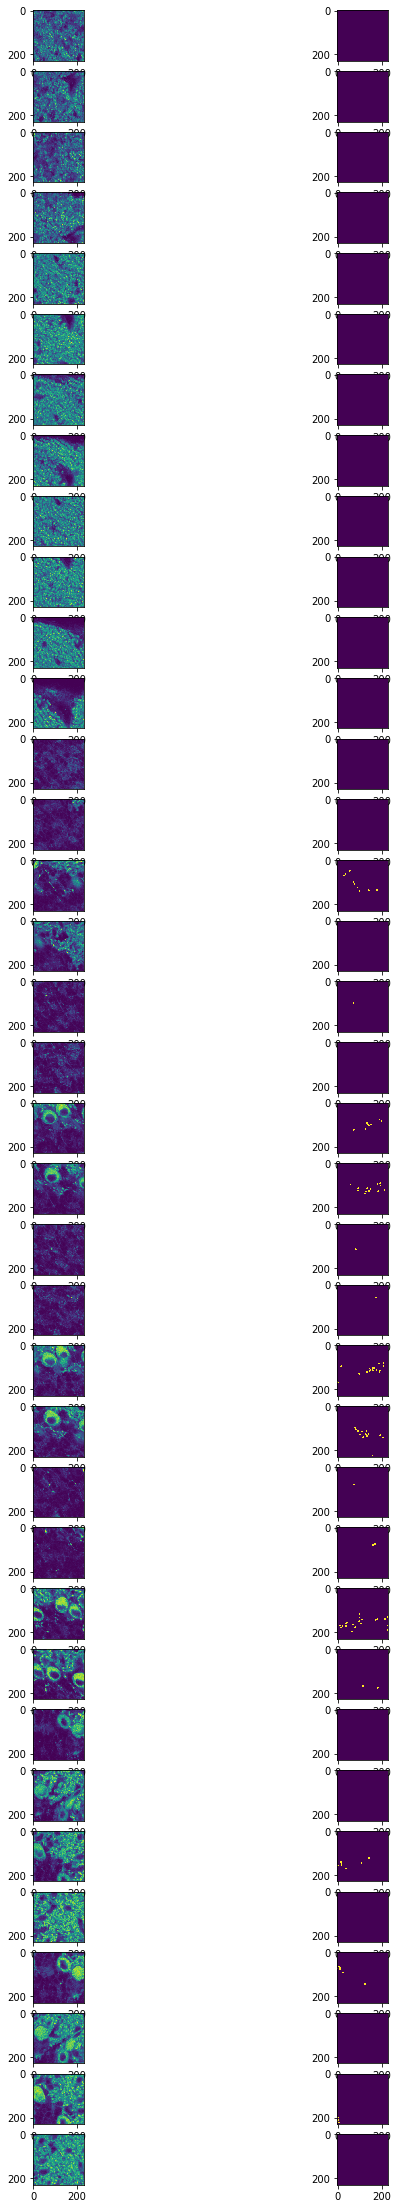

In [36]:
z=len(trainingMasks)
plt.figure(figsize=(10,40))
for n in range(0,len(trainingImages)):
    plt.subplot(z,2, 2*n+1)
    plt.imshow(trainingImages[n].mean(axis=0))
    plt.subplot(z,2, 2*n+2)
    plt.imshow(trainingMasks[n])

In [9]:
def inference(net,image,get_inter = False):
    x = np.expand_dims(image,0)
    vx = torch.from_numpy(x).float().cpu()
    res,inter = net(vx)
    if get_inter:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

def estimate_quality(collman,net,layer,slices=[2,3,4,5,6],th=0.4):#####
    mprecision=[]
    mrecall=[]
    mf1_score=[]
    auc_score=[]
    dic=[]
    
    for s in slices:
        y  = inference(net,collman[:,s])
        plt.imshow(y[0].mean(axis=0))
        y_gt = make_labels(collman[:,0],np.array(layer[s])[:,0],np.array(layer[s])[:,1])

        fpr, tpr, thresholds = roc_curve( y_gt.flatten(),y[0,0].flatten())
        auc_score.append(auc(fpr, tpr))
            
        gt_pts = np.array([np.array(layer[s])[:,1],np.array(layer[s])[:,0]]).transpose(1,0)

        coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>th)) if p.area>3])

        if coords.size == 0:
            print("empty")
            dog_pts = np.array()
        else:
            dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
        
        precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=10.)
        
        mprecision.append(precision)
        mrecall.append(recall)
        mf1_score.append(f1_score)
        dic.append(abs(float(gt_pts.shape[0])-float(dog_pts.shape[0])))
        
    return np.mean(mf1_score),np.mean(mprecision),np.mean(mrecall),np.mean(auc_score),np.mean(dic)

In [6]:
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#net = dognet.SimpleAnisotropic(3,15,3,2,learn_amplitude=False).to(device)
net = dognet.SimpleAnisotropic(3,15,36).to(device)
net.weights_init()

print(dognet.get_n_params(net))
net,errors =dognet.train_routine(net.to(device),dognet.create_generator(trainingImages,trainingMasks),n_iter=300,margin=5,loss='softdice',lr=0.001)

758
tensor([40854.]) (10, 1, 64, 64) 4096 0.0 0.0
<function soft_dice_loss at 0x12a9a6400>
Training started!


/anaconda3/envs/dogsenv/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[====================] 100%
Training finished!


In [10]:
z=len(trainingMasks)
#x=random.randint(0,z-2)
x=14
print(x)

num = int(x/4)

if x%4 == 0:
    quad = "LL"
elif x%4 == 1:
    quad = "LR"
elif x%4 == 2:
    quad = "UL"
elif x%4 == 3:
    quad = "UR"
    
lines = []
    
with open("../datasets/flocculusA/imagesUsed.txt") as fin:
    lines = fin.readlines()

lines.sort()
fname = lines[num]
fname = fname[:12]

st = "../datasets/flocculusA/trainingCoordinates/%s_%s_coords" % (fname,quad)

print(st)

with open(st) as fi:
    coors = fi.readlines()

coordins = [[] for j in range(0,len(coors))]

for i in range(0,len(coors)):
    xy = coors[i].split(",")
    xy[1]=xy[1][:24]
    xy[0]=float(xy[0])
    xy[1]=float(xy[1])
    coordins[i]=np.array(xy)

b = [[] for j in range(0,len(trainingImages))]
b[x]=coordins
print(coordins)

14
../datasets/flocculusA/trainingCoordinates/Track0030_13_UL_coords
[array([30.00782807, 69.91009773]), array([73.7292966 , 98.20045972]), array([ 79.73028247, 107.63058038]), array([ 91.73225423, 123.06168692]), array([101.16237489, 138.49279346]), array([179.17519128, 135.06365867]), array([57.44090636, 47.62072162]), array([142.31199233, 135.92094237]), array([37.72338134, 61.33726076])]


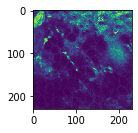

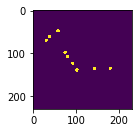

empty


TypeError: Required argument 'object' (pos 1) not found

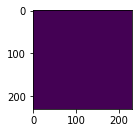

In [11]:
plt.subplot(2,3,1)
plt.imshow(trainingImages[x].mean(axis=0))
plt.show()
plt.subplot(2,3,2)
plt.imshow(trainingMasks[x])
plt.show()
plt.subplot(2,3,3)
print(estimate_quality(collman,net,b,slices=range(x,x+1)))

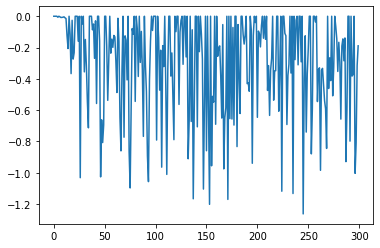

In [9]:
plt.plot(np.log(errors))